In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings

from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skfeature.function.similarity_based import fisher_score, reliefF
from skfeature.function.statistical_based import chi_square, f_score
from boruta import BorutaPy
from sklearn.feature_selection import RFE, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
%matplotlib inline
SEED=50

In [2]:
cns = pd.read_csv('cns.csv')
cns.head()

,x.AFFX.BioB.5.at,x.AFFX.BioB.M.at,x.AFFX.BioB.3.at,x.AFFX.BioC.5.at,x.AFFX.BioC.3.at,x.AFFX.BioDn.5.at,x.AFFX.BioDn.3.at,x.AFFX.CreX.5.at,x.AFFX.CreX.3.at,x.AFFX.BioB.5.st,...,x.U58516.at,x.U73738.at,x.X06956.at,x.X16699.at,x.X83863.at,x.Z17240.at,x.L49218.f.at,x.M71243.f.at,x.Z78285.f.at,y
1,-0.231140,-0.242715,-0.183060,-0.041937,-0.479553,-0.394078,0.039086,-0.291240,-0.228024,-0.100701,...,-0.050841,-0.309048,-0.261858,-0.197752,0.110761,0.069804,-0.193300,0.013711,-0.199087,2
2,-0.217881,-0.327010,-0.219228,-0.087645,-0.463983,-0.511138,0.144985,-0.428505,-0.194977,-0.262790,...,0.464738,-0.199019,0.025077,-0.254707,0.207858,-0.117734,-0.102015,0.096483,-0.191834,2
3,-0.308496,-0.256856,-0.299157,-0.197525,-0.239276,-0.283775,-0.120614,-0.360136,-0.140941,-0.166761,...,-0.004149,-0.084356,-0.233233,-0.227740,0.065071,-0.173902,-0.274436,-0.159619,-0.239276,2
4,-0.262352,-0.259978,-0.154330,-0.249294,-0.364042,-0.706703,-0.229510,-0.338323,-0.193107,-0.089043,...,0.463725,0.010669,-0.253647,-0.255625,0.405164,-0.132568,-0.175697,0.021353,-0.223575,2
5,-0.274458,-0.154017,-0.061023,-0.098712,-0.452661,-0.454710,-0.274458,-0.367451,-0.183922,-0.108544,...,0.068021,0.089733,-0.383428,-0.210960,0.016403,-0.112231,-0.308050,0.056141,-0.375645,2


In [3]:
print(cns.isnull().values.any())


False


In [4]:
features=cns.iloc[:,0:-1]
labels=cns.iloc[:,-1]

In [5]:
features.columns

Index(['x.AFFX.BioB.5.at', 'x.AFFX.BioB.M.at', 'x.AFFX.BioB.3.at',
       'x.AFFX.BioC.5.at', 'x.AFFX.BioC.3.at', 'x.AFFX.BioDn.5.at',
       'x.AFFX.BioDn.3.at', 'x.AFFX.CreX.5.at', 'x.AFFX.CreX.3.at',
       'x.AFFX.BioB.5.st',
       ...
       'x.U48730.at', 'x.U58516.at', 'x.U73738.at', 'x.X06956.at',
       'x.X16699.at', 'x.X83863.at', 'x.Z17240.at', 'x.L49218.f.at',
       'x.M71243.f.at', 'x.Z78285.f.at'],
      dtype='object', length=7128)

In [6]:
# Crear lista con nombres variables
feature_labels = list(features.columns)

In [7]:
type(features)

pandas.core.frame.DataFrame

In [8]:
feature_labels[0:10]

['x.AFFX.BioB.5.at',
 'x.AFFX.BioB.M.at',
 'x.AFFX.BioB.3.at',
 'x.AFFX.BioC.5.at',
 'x.AFFX.BioC.3.at',
 'x.AFFX.BioDn.5.at',
 'x.AFFX.BioDn.3.at',
 'x.AFFX.CreX.5.at',
 'x.AFFX.CreX.3.at',
 'x.AFFX.BioB.5.st']

In [9]:
# Estandarizar

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(features)

In [10]:
X

array([[0.76977144, 0.72460051, 0.73475917, ..., 0.82484924, 0.86478722,
        0.83183692],
       [0.79632123, 0.51901313, 0.65615052, ..., 1.        , 1.        ,
        0.8467659 ],
       [0.61487744, 0.69011213, 0.48243042, ..., 0.66917029, 0.58164346,
        0.74911813],
       ...,
       [0.43085597, 0.3112476 , 0.16300848, ..., 0.2510696 , 0.03330701,
        0.22218608],
       [0.58932403, 0.44619507, 0.72462594, ..., 0.9068894 , 0.85566845,
        0.85846072],
       [0.50712403, 0.40712679, 0.52396387, ..., 0.85344729, 0.83220874,
        0.80065326]])

In [11]:
Y = np.transpose(np.asarray(labels.values - 1, dtype=int))


In [12]:
Y

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=labels,test_size=0.33, random_state=SEED)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 7128), (20, 7128), (40,), (20,))

# 1. SVC

In [15]:
# Elegir SVC Lineal

clf_svc = SVC(kernel='linear', C=1, probability=True, random_state=SEED) 

In [16]:
%%time
clf_svc.fit(X_train, y_train)

CPU times: user 312 ms, sys: 7.94 ms, total: 320 ms
Wall time: 79.9 ms


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=50,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
y_predict_svc = clf_svc.predict(X_test)
print ("Predicted Value:", y_predict_svc)

Predicted Value: [1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1]


In [18]:
# Precision del modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_predict_svc))

Accuracy: 0.7


In [19]:
print(metrics.classification_report(y_test,y_predict_svc))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.73      0.85      0.79        13

    accuracy                           0.70        20
   macro avg       0.67      0.64      0.64        20
weighted avg       0.69      0.70      0.69        20



In [20]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_svc.predict_proba(X_test)[:,1]))

ROC-AUC: 0.5824175824175825


# 2. NAIVE BAYES

In [21]:
# Crear clasificador Gaussiano

clf_nb = GaussianNB()

In [22]:
%%time
clf_nb.fit(X_train, y_train)

CPU times: user 17.1 ms, sys: 0 ns, total: 17.1 ms
Wall time: 4.21 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [23]:
#Predicciones

y_predict_nb = clf_nb.predict(X_test)
print ("Predicted Value:", y_predict_nb)

Predicted Value: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]


In [24]:
# Precision

print("Accuracy:",metrics.accuracy_score(y_test, y_predict_nb))

Accuracy: 0.75


In [25]:
print(metrics.classification_report(y_test,y_predict_nb))



              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.72      1.00      0.84        13

    accuracy                           0.75        20
   macro avg       0.86      0.64      0.64        20
weighted avg       0.82      0.75      0.70        20



In [26]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_nb.predict_proba(X_test)[:,1]))

ROC-AUC: 0.6153846153846154


# 3. RANDOM FORESTS

In [27]:
# Crear clasificador

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', max_depth=5, random_state=SEED)



In [28]:
%%time
clf_rf.fit(X_train,y_train)



CPU times: user 272 ms, sys: 25.9 ms, total: 298 ms
Wall time: 151 ms


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=50, verbose=0, warm_start=False)

In [29]:
#Predicciones

y_predict_rf = clf_rf.predict(X_test)
print ("Predicted Value:", y_predict_rf)

Predicted Value: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [30]:
# Precision

print("Accuracy:",metrics.accuracy_score(y_test, y_predict_rf))

Accuracy: 0.65


In [31]:
print(metrics.classification_report(y_test,y_predict_rf))


              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.67      0.92      0.77        13

    accuracy                           0.65        20
   macro avg       0.58      0.53      0.50        20
weighted avg       0.61      0.65      0.58        20



In [32]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_rf.predict_proba(X_test)[:,1]))

ROC-AUC: 0.5054945054945056


## SELECCIONAR VARIABLES USANDO PUNTUACION F

In [33]:
%%time
score_f = f_score.f_score(X_train, y_train)


CPU times: user 8.9 ms, sys: 66 µs, total: 8.97 ms
Wall time: 7.9 ms


In [34]:
score_f_df = pd.Series(score_f,index=features.columns.values).sort_values(ascending=False)


In [35]:
score_f_df.head(10)

x.U07563.cds1.at    15.634207
x.U34038.at         12.851574
x.Z11899.s.at       12.647165
x.U35048.at         11.276424
x.J02611.at         10.769984
x.U35139.at         10.646060
x.U82306.at         10.244439
x.U78876.at         10.067017
x.L05628.s.at        9.505626
x.X57129.at          9.422457
dtype: float64

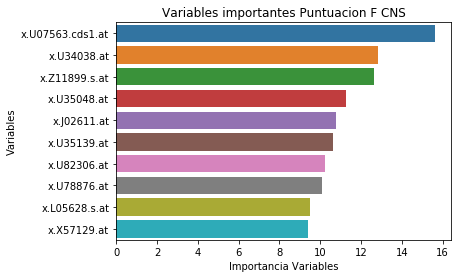

In [36]:
# Representacion grafica

sns.barplot(x=score_f_df[0:10,], y=score_f_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Puntuacion F CNS")
plt.savefig("Variables Puntuacion F CNS.pdf", dpi=300)
plt.show()

In [37]:
# Ordenar variables

idx_f = f_score.feature_ranking(score_f)
idx_f[0:10]

array([2670, 3075, 6719, 3088, 1053, 3091, 3833, 3745, 6031, 4301])

In [38]:
features.columns.values[[2670, 3075, 6719, 3088, 1053, 3091, 3833, 3745, 6031, 4301]]

array(['x.U07563.cds1.at', 'x.U34038.at', 'x.Z11899.s.at', 'x.U35048.at',
       'x.J02611.at', 'x.U35139.at', 'x.U82306.at', 'x.U78876.at',
       'x.L05628.s.at', 'x.X57129.at'], dtype=object)

In [39]:
# Especificar 10 variables

num_fea = 10
    
sel_f_train = X_train[:, idx_f[0:num_fea]]

sel_f_test = X_test[:, idx_f[0:num_fea]]

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [40]:
%%time
clf_svc_fsc = clf_svc.fit(sel_f_train, y_train)

CPU times: user 1.77 ms, sys: 123 µs, total: 1.89 ms
Wall time: 1.19 ms


In [41]:
%%time
clf_nb_fsc = clf_nb.fit(sel_f_train, y_train)

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.29 ms


In [42]:
%%time
clf_rf_fsc = clf_rf.fit(sel_f_train, y_train)

CPU times: user 91.1 ms, sys: 20.9 ms, total: 112 ms
Wall time: 137 ms


In [43]:
clf_svc_fsc.predict_proba(sel_f_test)

array([[7.34303520e-07, 9.99999266e-01],
       [5.54058578e-02, 9.44594142e-01],
       [7.10021256e-01, 2.89978744e-01],
       [5.19195249e-01, 4.80804751e-01],
       [7.87447496e-03, 9.92125525e-01],
       [6.50821612e-03, 9.93491784e-01],
       [6.60028708e-01, 3.39971292e-01],
       [6.34771132e-01, 3.65228868e-01],
       [3.21422065e-01, 6.78577935e-01],
       [4.21289013e-01, 5.78710987e-01],
       [9.89533329e-06, 9.99990105e-01],
       [3.76926314e-01, 6.23073686e-01],
       [5.11539440e-01, 4.88460560e-01],
       [2.84509028e-01, 7.15490972e-01],
       [8.05018136e-01, 1.94981864e-01],
       [5.64731242e-01, 4.35268758e-01],
       [2.91198702e-01, 7.08801298e-01],
       [7.16320389e-01, 2.83679611e-01],
       [3.33899665e-02, 9.66610034e-01],
       [4.72193009e-02, 9.52780699e-01]])

In [44]:
y_fsc_predict_rf = clf_rf_fsc.predict(sel_f_test)
y_fsc_predict_nb = clf_nb_fsc.predict(sel_f_test)
y_fsc_predict_svc = clf_svc_fsc.predict(sel_f_test)

In [45]:
# Exactitud

print("Accuracy F1 Score SVC:",metrics.accuracy_score(y_test, y_fsc_predict_svc))
print("Accuracy F1 Score NB:",metrics.accuracy_score(y_test, y_fsc_predict_nb))
print("Accuracy F1 Score RF:",metrics.accuracy_score(y_test, y_fsc_predict_rf))

Accuracy F1 Score SVC: 0.65
Accuracy F1 Score NB: 0.7
Accuracy F1 Score RF: 0.65


In [46]:
# Puntuacion ROC-AUC 
print("ROC-AUC SVC:",metrics.roc_auc_score(y_test,clf_svc_fsc.predict_proba(sel_f_test)[:,1]))
print("ROC-AUC NB:",metrics.roc_auc_score(y_test,clf_nb_fsc.predict_proba(sel_f_test)[:,1]))
print("ROC-AUC RF:",metrics.roc_auc_score(y_test,clf_rf_fsc.predict_proba(sel_f_test)[:,1]))

ROC-AUC SVC: 0.5714285714285714
ROC-AUC NB: 0.5714285714285714
ROC-AUC RF: 0.5384615384615385


In [47]:
print(metrics.classification_report(y_test,y_fsc_predict_svc))
print(metrics.classification_report(y_test,y_fsc_predict_nb))
print(metrics.classification_report(y_test,y_fsc_predict_rf))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.75      0.69      0.72        13

    accuracy                           0.65        20
   macro avg       0.62      0.63      0.63        20
weighted avg       0.66      0.65      0.65        20

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.77      0.77      0.77        13

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20

              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20



## SELECCIONAR VARIABLES USANDO CHI-CUADRADO

In [48]:
%%time
score_chi = chi_square.chi_square(X_train, y_train)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 3.35 ms


In [49]:
score_chi_df = pd.Series(score_chi,index=features.columns.values).sort_values(ascending=False)


In [50]:
score_chi_df.head(10)

x.J02611.at             2.279684
x.HG3431.HT3616.s.at    1.984059
x.U07563.cds1.at        1.649041
x.L27560.at             1.513892
x.HG4318.HT4588.s.at    1.499029
x.HG3543.HT3739.at      1.441188
x.J04080.at             1.396253
x.X76302.at             1.265272
x.U35048.at             1.216827
x.M25667.at             1.193368
dtype: float64

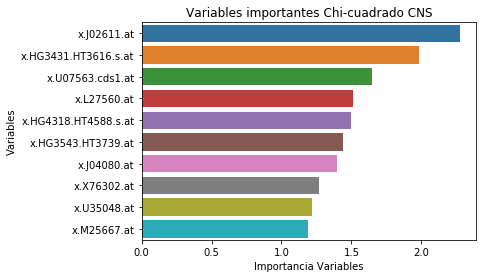

In [51]:
# Representacion grafica

sns.barplot(x=score_chi_df[0:10,], y=score_chi_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Chi-cuadrado CNS")
plt.savefig("Variables importantes Chi-cuadrado CNS.pdf", dpi=300)
plt.show()

In [52]:
# Ordenar variables

idx_chi = chi_square.feature_ranking(score_chi)
idx_chi[0:10]

array([1053, 5842, 2670, 1442, 5886, 5274, 1100, 4575, 3088, 6971])

In [53]:
features.columns.values[[1053, 5842, 2670, 1442, 5886, 5274, 1100, 4575, 3088, 6971]]

array(['x.J02611.at', 'x.HG3431.HT3616.s.at', 'x.U07563.cds1.at',
       'x.L27560.at', 'x.HG4318.HT4588.s.at', 'x.HG3543.HT3739.at',
       'x.J04080.at', 'x.X76302.at', 'x.U35048.at', 'x.M25667.at'],
      dtype=object)

In [54]:
# Especificar 10 variables

num_fea = 10
    
sel_chi_train = X_train[:, idx_chi[0:num_fea]]

sel_chi_test = X_test[:, idx_chi[0:num_fea]]


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [55]:
%%time
clf_svc_chi = clf_svc.fit(sel_chi_train, y_train)

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.16 ms


In [56]:
%%time
clf_nb_chi = clf_nb.fit(sel_chi_train, y_train)

CPU times: user 856 µs, sys: 15 µs, total: 871 µs
Wall time: 769 µs


In [57]:
%%time
clf_rf_chi = clf_rf.fit(sel_chi_train, y_train)

CPU times: user 118 ms, sys: 27.2 ms, total: 146 ms
Wall time: 135 ms


In [58]:
y_chi_predict_rf = clf_rf_chi.predict(sel_chi_test)
y_chi_predict_nb = clf_nb_chi.predict(sel_chi_test)
y_chi_predict_svc = clf_svc_chi.predict(sel_chi_test)

In [59]:
# Exactitud


print("Accuracy Chi-cuadrado SVC:",metrics.accuracy_score(y_test, y_chi_predict_svc))
print("Accuracy Chi-cuadrado NB:",metrics.accuracy_score(y_test, y_chi_predict_nb))
print("Accuracy Chi-cuadrado RF:",metrics.accuracy_score(y_test, y_chi_predict_rf))


Accuracy Chi-cuadrado SVC: 0.65
Accuracy Chi-cuadrado NB: 0.65
Accuracy Chi-cuadrado RF: 0.6


In [60]:
# Puntuacion ROC-AUC 
print("ROC-AUC Chi-cuadrado SVC:",metrics.roc_auc_score(y_test,clf_svc_chi.predict_proba(sel_chi_test)[:,1]))
print("ROC-AUC Chi-cuadrado NB:",metrics.roc_auc_score(y_test,clf_nb_chi.predict_proba(sel_chi_test)[:,1]))
print("ROC-AUC Chi-cuadrado RF:",metrics.roc_auc_score(y_test,clf_rf_chi.predict_proba(sel_chi_test)[:,1]))

ROC-AUC Chi-cuadrado SVC: 0.5714285714285715
ROC-AUC Chi-cuadrado NB: 0.6373626373626374
ROC-AUC Chi-cuadrado RF: 0.5714285714285714


In [61]:
print(metrics.classification_report(y_test,y_chi_predict_svc))
print(metrics.classification_report(y_test,y_chi_predict_nb))
print(metrics.classification_report(y_test,y_chi_predict_rf))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.75      0.69      0.72        13

    accuracy                           0.65        20
   macro avg       0.62      0.63      0.63        20
weighted avg       0.66      0.65      0.65        20

              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.69      0.69      0.69        13

    accuracy                           0.60        20
   macro avg       0.56      0.56      0.56        20
weighted avg       0.60      0.60      0.60        20



## SELECCIONAR VARIABLES USANDO Fisher 

In [62]:
%%time
score_fisher = fisher_score.fisher_score(X_train, y_train)

CPU times: user 30.8 ms, sys: 3.94 ms, total: 34.8 ms
Wall time: 9.83 ms


In [63]:
score_fisher_df = pd.Series(score_fisher,index=features.columns.values).sort_values(ascending=False)


In [64]:
score_fisher_df.head(10)

x.U07563.cds1.at    0.411427
x.U34038.at         0.338199
x.Z11899.s.at       0.332820
x.U35048.at         0.296748
x.J02611.at         0.283421
x.U35139.at         0.280159
x.U82306.at         0.269590
x.U78876.at         0.264922
x.L05628.s.at       0.250148
x.X57129.at         0.247959
dtype: float64

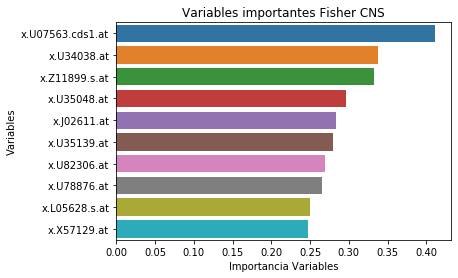

In [65]:
# Representacion grafica

sns.barplot(x=score_fisher_df[0:10,], y=score_fisher_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Fisher CNS")
plt.savefig("Variables importantes Fisher CNS.pdf", dpi=300)
plt.show()

In [66]:
features.columns.values[[2670, 3075, 6719, 3088, 1053, 3091, 3833, 3745, 6031, 4301]]

array(['x.U07563.cds1.at', 'x.U34038.at', 'x.Z11899.s.at', 'x.U35048.at',
       'x.J02611.at', 'x.U35139.at', 'x.U82306.at', 'x.U78876.at',
       'x.L05628.s.at', 'x.X57129.at'], dtype=object)

In [67]:
# Ordenar variables

idx_fisher = fisher_score.feature_ranking(score_fisher)
idx_fisher[0:10]

array([2670, 3075, 6719, 3088, 1053, 3091, 3833, 3745, 6031, 4301])

In [68]:
# Especificar 10 variables

num_fea = 10
    
sel_fisher_train = X_train[:, idx_fisher[0:num_fea]]

sel_fisher_test = X_test[:, idx_fisher[0:num_fea]]


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [69]:
%%time
clf_svc_f = clf_svc.fit(sel_fisher_train, y_train)

CPU times: user 1.11 ms, sys: 71 µs, total: 1.19 ms
Wall time: 799 µs


In [70]:
%%time
clf_nb_f = clf_nb.fit(sel_fisher_train, y_train)

CPU times: user 1.04 ms, sys: 0 ns, total: 1.04 ms
Wall time: 834 µs


In [71]:
%%time
clf_rf_f = clf_rf.fit(sel_fisher_train, y_train)

CPU times: user 88.5 ms, sys: 24.5 ms, total: 113 ms
Wall time: 140 ms


In [72]:
y_fisher_predict_rf = clf_rf_f.predict(sel_fisher_test)
y_fisher_predict_nb = clf_nb_f.predict(sel_fisher_test)
y_fisher_predict_svc = clf_svc_f.predict(sel_fisher_test)

In [73]:
# Exactitud


print("Accuracy Fisher SVC:",metrics.accuracy_score(y_test, y_fisher_predict_svc))
print("Accuracy Fisher NB:",metrics.accuracy_score(y_test, y_fisher_predict_nb))
print("Accuracy Fisher RF:",metrics.accuracy_score(y_test, y_fisher_predict_rf))


Accuracy Fisher SVC: 0.65
Accuracy Fisher NB: 0.7
Accuracy Fisher RF: 0.65


In [74]:
# Puntuacion ROC-AUC 
print("ROC-AUC Fisher SVC:",metrics.roc_auc_score(y_test,clf_svc_f.predict_proba(sel_fisher_test)[:,1]))
print("ROC-AUC Fisher NB:",metrics.roc_auc_score(y_test,clf_nb_f.predict_proba(sel_fisher_test)[:,1]))
print("ROC-AUC Fisher RF:",metrics.roc_auc_score(y_test,clf_rf_f.predict_proba(sel_fisher_test)[:,1]))

ROC-AUC Fisher SVC: 0.5714285714285714
ROC-AUC Fisher NB: 0.5714285714285714
ROC-AUC Fisher RF: 0.5384615384615385


In [75]:
print(metrics.classification_report(y_test,y_fisher_predict_svc))
print(metrics.classification_report(y_test,y_fisher_predict_nb))
print(metrics.classification_report(y_test,y_fisher_predict_rf))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.75      0.69      0.72        13

    accuracy                           0.65        20
   macro avg       0.62      0.63      0.63        20
weighted avg       0.66      0.65      0.65        20

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.77      0.77      0.77        13

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20

              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20



## SELECCIONAR VARIABLES USANDO reliefF

In [76]:
%%time

score_relief = reliefF.reliefF(X_train, y_train, k=5)


CPU times: user 42 ms, sys: 113 µs, total: 42.2 ms
Wall time: 41.6 ms


In [77]:
score_relief

array([ 0.97748275,  1.18517819,  0.20225874, ..., -0.11452912,
       -0.33643507,  0.1844747 ])

In [78]:
score_relief_df = pd.Series(score_relief,index=features.columns.values).sort_values(ascending=False)


In [79]:
score_relief_df.head(20)

x.U07563.cds1.at             3.608279
x.U21858.at                  3.312530
x.M14328.s.at                3.169493
x.Z11899.s.at                3.098933
x.M32886.at                  3.008990
x.U25165.at                  2.762253
x.Z50022.at                  2.532475
x.U26403.at                  2.526985
x.X13293.at                  2.480808
x.X94703.at                  2.475575
x.U21936.at                  2.457847
x.U79751.at                  2.449975
x.HG3432.HT3620.s.at         2.433598
x.M20530.at                  2.411702
x.U00802.s.at                2.402206
x.AFFX.HSAC07.X00351.3.st    2.375704
x.L05425.at                  2.374156
x.K03008.cds1.at             2.363461
x.AF001787.s.at              2.338366
x.D43682.s.at                2.320372
dtype: float64

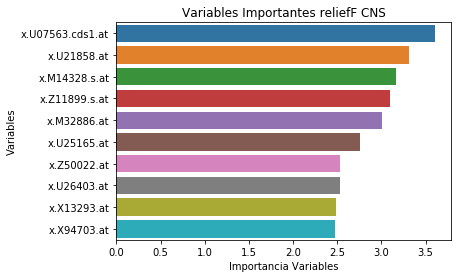

In [80]:
# Representar graficamente

sns.barplot(x=score_relief_df[0:10,], y=score_relief_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables Importantes reliefF CNS")
plt.savefig("Variables importantes reliefF CNS.pdf", dpi=300)

plt.show()

In [81]:
# Ordenar variables

idx_relief = reliefF.feature_ranking(score_relief)
idx_relief

array([2670, 2914, 6178, ..., 4340, 6612,  602])

In [82]:
idx_relief.shape

(7128,)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [83]:
# Seleccionar 10:

num_fea = 10
    
sel_relief_train = X_train[:, idx_relief[0:num_fea]]

sel_relief_test = X_test[:, idx_relief[0:num_fea]]


In [84]:
sel_relief_train.shape

(40, 10)

In [85]:
%%time
clf_svc_rl = clf_svc.fit(sel_relief_train, y_train)

CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 895 µs


In [86]:
%%time
clf_nb_rl = clf_nb.fit(sel_relief_train, y_train)

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 1.07 ms


In [87]:
%%time
clf_rf_rl = clf_rf.fit(sel_relief_train, y_train)

CPU times: user 90.4 ms, sys: 16.5 ms, total: 107 ms
Wall time: 135 ms


In [88]:
y_rl_predict_svc = clf_svc_rl.predict(sel_relief_test)
y_rl_predict_nb = clf_nb_rl.predict(sel_relief_test)
y_rl_predict_rf = clf_rf_rl.predict(sel_relief_test)

In [89]:
# Exactitud

print("Accuracy reliefF SVC:",metrics.accuracy_score(y_test, y_rl_predict_svc))
print("Accuracy reliefF NB:",metrics.accuracy_score(y_test, y_rl_predict_nb))
print("Accuracy reliefF RF:",metrics.accuracy_score(y_test, y_rl_predict_rf))

Accuracy reliefF SVC: 0.65
Accuracy reliefF NB: 0.6
Accuracy reliefF RF: 0.6


In [90]:
# Puntuacion ROC-AUC 
print("ROC-AUC reliefF SVC:",metrics.roc_auc_score(y_test,clf_svc_rl.predict_proba(sel_relief_test)[:,1]))
print("ROC-AUC reliefF NB:",metrics.roc_auc_score(y_test,clf_nb_rl.predict_proba(sel_relief_test)[:,1]))
print("ROC-AUC reliefF RF:",metrics.roc_auc_score(y_test,clf_rf_rl.predict_proba(sel_relief_test)[:,1]))

ROC-AUC reliefF SVC: 0.6483516483516484
ROC-AUC reliefF NB: 0.6263736263736264
ROC-AUC reliefF RF: 0.5769230769230769


In [91]:
# Metricas

print(metrics.classification_report(y_test,y_rl_predict_svc))
print(metrics.classification_report(y_test,y_rl_predict_nb))
print(metrics.classification_report(y_test,y_rl_predict_rf))

              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.69      0.85      0.76        13

    accuracy                           0.65        20
   macro avg       0.59      0.57      0.56        20
weighted avg       0.62      0.65      0.62        20

              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.69      0.69      0.69        13

    accuracy                           0.60        20
   macro avg       0.56      0.56      0.56        20
weighted avg       0.60      0.60      0.60        20

              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.67      0.77      0.71        13

    accuracy                           0.60        20
   macro avg       0.53      0.53      0.52        20
weighted avg       0.57      0.60      0.58        20



## SELECCIONAR VARIABLES CON BORUTA

In [92]:
boruta_selector = BorutaPy(clf_rf, n_estimators='auto', verbose=0, random_state=SEED, max_iter = 100, perc = 99.5, alpha=0.01)


In [93]:
%%time
boruta_selector.fit(X_train, y_train)

CPU times: user 1min 55s, sys: 12.3 s, total: 2min 7s
Wall time: 59 s


BorutaPy(alpha=0.01,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=205, n_jobs=-1,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x7f436f87f288>,
                                          verbose=0, warm_start=False),
         max_iter=

In [94]:
boruta_selector.n_features_

10

In [95]:
boruta_selector.support_

array([False, False, False, ..., False, False, False])

In [96]:
boruta_selector.ranking_


array([ 756, 1082, 5202, ..., 6543, 6543, 5202])

In [97]:
score_boruta_df = pd.Series(boruta_selector.ranking_,index=features.columns.values).sort_values(ascending=True)
score_boruta_df.head(11)

x.U66711.rna1.s.at    1
x.J02611.at           1
x.U35139.at           1
x.Z11899.s.at         1
x.K03008.cds1.at      1
x.U78876.at           1
x.M26692.s.at         1
x.M27281.at           1
x.U07563.cds1.at      1
x.M18728.at           1
x.U36759.s.at         2
dtype: int64

In [98]:
score_boruta_df.loc['x.J02611.at',]

1

In [99]:
sel_boruta_train = boruta_selector.transform(X_train)

sel_boruta_test = boruta_selector.transform(X_test)

In [100]:
print(sel_boruta_train.shape)
print(sel_boruta_test.shape)

(40, 10)
(20, 10)


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [101]:
%%time
clf_svc_b = clf_svc.fit(sel_boruta_train, y_train)

CPU times: user 3.69 ms, sys: 389 µs, total: 4.07 ms
Wall time: 966 µs


In [102]:
%%time
clf_nb_b = clf_nb.fit(sel_boruta_train, y_train)

CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 832 µs


In [103]:
%%time
clf_rf_b = clf_rf.fit(sel_boruta_train, y_train)

CPU times: user 488 ms, sys: 33.8 ms, total: 521 ms
Wall time: 183 ms


In [104]:
y_boruta_predict_svc = clf_svc_b.predict(sel_boruta_test)
y_boruta_predict_nb = clf_nb_b.predict(sel_boruta_test)
y_boruta_predict_rf = clf_rf_b.predict(sel_boruta_test)

In [105]:
print("Accuracy Boruta SVC:",metrics.accuracy_score(y_test, y_boruta_predict_svc))
print("Accuracy Boruta NB:",metrics.accuracy_score(y_test, y_boruta_predict_nb))
print("Accuracy Boruta RF:",metrics.accuracy_score(y_test, y_boruta_predict_rf))

Accuracy Boruta SVC: 0.4
Accuracy Boruta NB: 0.55
Accuracy Boruta RF: 0.5


In [106]:
print(metrics.classification_report(y_test,y_boruta_predict_svc))
print(metrics.classification_report(y_test,y_boruta_predict_nb))
print(metrics.classification_report(y_test,y_boruta_predict_rf))

              precision    recall  f1-score   support

           0       0.22      0.29      0.25         7
           1       0.55      0.46      0.50        13

    accuracy                           0.40        20
   macro avg       0.38      0.37      0.37        20
weighted avg       0.43      0.40      0.41        20

              precision    recall  f1-score   support

           0       0.33      0.29      0.31         7
           1       0.64      0.69      0.67        13

    accuracy                           0.55        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.53      0.55      0.54        20

              precision    recall  f1-score   support

           0       0.20      0.14      0.17         7
           1       0.60      0.69      0.64        13

    accuracy                           0.50        20
   macro avg       0.40      0.42      0.40        20
weighted avg       0.46      0.50      0.48        20



In [107]:
# Puntuacion ROC-AUC 
print("ROC-AUC Boruta SVC:",metrics.roc_auc_score(y_test,clf_svc_b.predict_proba(sel_boruta_test)[:,1]))
print("ROC-AUC Boruta NB:",metrics.roc_auc_score(y_test,clf_nb_b.predict_proba(sel_boruta_test)[:,1]))
print("ROC-AUC Boruta RF:",metrics.roc_auc_score(y_test,clf_rf_b.predict_proba(sel_boruta_test)[:,1]))

ROC-AUC Boruta SVC: 0.4505494505494506
ROC-AUC Boruta NB: 0.43956043956043955
ROC-AUC Boruta RF: 0.24175824175824176


## SELECCIONAR VARIABLES USANDO RFE (Eliminar recursivamente)

In [108]:
# RFE
rfe = RFE(estimator=clf_svc, n_features_to_select=10)



In [109]:
%%time
rfe = rfe.fit(X_train, y_train)
 


CPU times: user 18min 21s, sys: 14.5 s, total: 18min 36s
Wall time: 4min 39s


In [110]:
%%time

sel_rfe_train = rfe.transform(X_train)

sel_rfe_test = rfe.transform(X_test)

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 1.06 ms


In [111]:
print(rfe.support_)
print(rfe.ranking_)

[False False False ... False False False]
[ 524  716 3262 ... 5009 5919 4850]


In [112]:
sel_rfe_train.shape

(40, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [113]:
%%time
clf_svc_r = clf_svc.fit(sel_rfe_train, y_train)

CPU times: user 0 ns, sys: 2.35 ms, total: 2.35 ms
Wall time: 1.8 ms


In [114]:
%%time
clf_nb_r = clf_nb.fit(sel_rfe_train, y_train)

CPU times: user 807 µs, sys: 18 µs, total: 825 µs
Wall time: 731 µs


In [115]:
%%time
clf_rf_r = clf_rf.fit(sel_rfe_train, y_train)

CPU times: user 154 ms, sys: 40.4 ms, total: 194 ms
Wall time: 164 ms


In [116]:
y_rfe_predict_svc = clf_svc_r.predict(sel_rfe_test)
y_rfe_predict_nb = clf_nb_r.predict(sel_rfe_test)
y_rfe_predict_rf = clf_rf_r.predict(sel_rfe_test)


In [117]:
# Exactitud

print("Accuracy SVC:",metrics.accuracy_score(y_test, y_rfe_predict_svc))
print("Accuracy NB:",metrics.accuracy_score(y_test, y_rfe_predict_nb))
print("Accuracy RF:",metrics.accuracy_score(y_test, y_rfe_predict_rf))

Accuracy SVC: 0.7
Accuracy NB: 0.6
Accuracy RF: 0.6


In [118]:
# Puntuacion ROC-AUC 
print("ROC-AUC RFE SVC:",metrics.roc_auc_score(y_test,clf_svc_r.predict_proba(sel_rfe_test)[:,1]))
print("ROC-AUC RFE NB:",metrics.roc_auc_score(y_test,clf_nb_r.predict_proba(sel_rfe_test)[:,1]))
print("ROC-AUC RFE RF:",metrics.roc_auc_score(y_test,clf_rf_r.predict_proba(sel_rfe_test)[:,1]))

ROC-AUC RFE SVC: 0.39560439560439564
ROC-AUC RFE NB: 0.41758241758241765
ROC-AUC RFE RF: 0.3406593406593407


In [119]:
print(metrics.classification_report(y_test,y_rfe_predict_svc))
print(metrics.classification_report(y_test,y_rfe_predict_nb))
print(metrics.classification_report(y_test,y_rfe_predict_rf))



              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20

              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.65      0.85      0.73        13

    accuracy                           0.60        20
   macro avg       0.49      0.49      0.47        20
weighted avg       0.54      0.60      0.55        20

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.63      0.92      0.75        13

    accuracy                           0.60        20
   macro avg       0.32      0.46      0.37        20
weighted avg       0.41      0.60      0.49        20



In [120]:
pd.Series(rfe.ranking_,index=features.columns.values).sort_values(ascending=True).head(11)

x.U35139.at                    1
x.X97544.at                    1
x.U07563.cds1.at               1
x.U66406.at                    1
x.AFFX.HUMGAPDH.M33197.5.at    1
x.J02611.at                    1
x.U66711.rna1.s.at             1
x.U18383.s.at                  1
x.U39318.at                    1
x.U39226.at                    1
x.L10333.s.at                  2
dtype: int64

## SELECCIONAR VARIABLES USANDO SELECCION DE VARIABLES HACIA DELANTE

In [121]:
# Tarda mucho tiempo, incluso seleccionando solo 5 variables. Tiempos similares en Google collab.
sfs1 = sfs(clf_rf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='f1',
           n_jobs= -1,
           cv=0)



In [122]:
%%time
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 7128 out of 7128 | elapsed:  9.3min finished

[2019-11-09 21:51:56] Features: 1/10

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 7120 out of 7120 | elapsed:  9.2min finished

[2019-11-09 23:06:00] Features: 9/10 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | ela

CPU times: user 1h 31min 27s, sys: 50.2 s, total: 1h 32min 17s
Wall time: 1h 32min 35s


[Parallel(n_jobs=-1)]: Done 7119 out of 7119 | elapsed:  9.3min finished

[2019-11-09 23:15:16] Features: 10/10 -- score: 1.0

In [123]:
# Mostrar variables seleccionadas

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [124]:
sfs1.k_score_

1.0

In [125]:
features.columns.values[[0,1,2,3,4,5,6,7,8,9]]

array(['x.AFFX.BioB.5.at', 'x.AFFX.BioB.M.at', 'x.AFFX.BioB.3.at',
       'x.AFFX.BioC.5.at', 'x.AFFX.BioC.3.at', 'x.AFFX.BioDn.5.at',
       'x.AFFX.BioDn.3.at', 'x.AFFX.CreX.5.at', 'x.AFFX.CreX.3.at',
       'x.AFFX.BioB.5.st'], dtype=object)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [126]:
%%time
clf_svc_sfs = clf_svc.fit(X_train[:, feat_cols], y_train)

CPU times: user 1.22 ms, sys: 14 µs, total: 1.23 ms
Wall time: 855 µs


In [127]:
%%time
clf_rf_sfs = clf_rf.fit(X_train[:, feat_cols], y_train)

CPU times: user 170 ms, sys: 32.2 ms, total: 202 ms
Wall time: 163 ms


In [128]:
%%time
clf_nb_sfs = clf_nb.fit(X_train[:, feat_cols], y_train)

CPU times: user 3.18 ms, sys: 29 µs, total: 3.21 ms
Wall time: 2.45 ms


In [129]:
y_sfs_predict_svc = clf_svc_sfs.predict(X_test[:, feat_cols])
y_sfs_predict_nb = clf_nb_sfs.predict(X_test[:, feat_cols])
y_sfs_predict_rf = clf_rf_sfs.predict(X_test[:, feat_cols])

In [130]:
# Exactitud

print("Accuracy SVC:",metrics.accuracy_score(y_test, y_sfs_predict_svc))
print("Accuracy NB:",metrics.accuracy_score(y_test, y_sfs_predict_nb))
print("Accuracy RF:",metrics.accuracy_score(y_test, y_sfs_predict_rf))

Accuracy SVC: 0.65
Accuracy NB: 0.55
Accuracy RF: 0.5


In [131]:
# Puntuacion ROC-AUC 
print("ROC-AUC SFS SVC:",metrics.roc_auc_score(y_test,clf_svc_sfs.predict_proba(X_test[:, feat_cols])[:,1]))
print("ROC-AUC SFS NB:",metrics.roc_auc_score(y_test,clf_nb_sfs.predict_proba(X_test[:, feat_cols])[:,1]))
print("ROC-AUC SFS RF:",metrics.roc_auc_score(y_test,clf_rf_sfs.predict_proba(X_test[:, feat_cols])[:,1]))

ROC-AUC SFS SVC: 0.5274725274725275
ROC-AUC SFS NB: 0.6043956043956045
ROC-AUC SFS RF: 0.4285714285714286


In [132]:
# Metricas

print(metrics.classification_report(y_test,y_sfs_predict_svc))
print(metrics.classification_report(y_test,y_sfs_predict_nb))
print(metrics.classification_report(y_test,y_sfs_predict_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      1.00      0.79        13

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20

              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.70      0.54      0.61        13

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.59      0.55      0.56        20

              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.62      0.62      0.62        13

    accuracy                           0.50        20
   macro avg       0.45      0.45      0.45        20
weighted avg       0.50      0.50      0.50        20



## SELECCIONAR VARIABLES USANDO ARBOLES DE DECISION

In [133]:
%%time

sfm = SelectFromModel(clf_rf, max_features=10, threshold=-np.inf)
sfm.fit(X_train, y_train)

CPU times: user 213 ms, sys: 56.2 ms, total: 270 ms
Wall time: 165 ms


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight='balanced',
                                                 criterion='gini', max_depth=5,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=205, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=<mtrand.RandomState object at 0x7f436f87f288>,
                    

In [134]:
# Imprimir variables importantes

l=[]
for feature_list_index in sfm.get_support(indices=True):
    feat = (feature_labels[feature_list_index])
    l.append(feat)

In [135]:
l

['x.D83243.at',
 'x.M24248.at',
 'x.M27281.at',
 'x.U07563.cds1.at',
 'x.U68031.at',
 'x.X57129.at',
 'x.X74295.at',
 'x.AB006781.s.at',
 'x.D43682.s.at',
 'x.X79200.at']

In [136]:

sel_rf_train = sfm.transform(X_train)
sel_rf_test = sfm.transform(X_test)

In [137]:
print(sel_rf_train.shape)
sel_rf_test.shape

(40, 10)


(20, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [138]:
%%time
clf_svc_rf = clf_svc.fit(sel_rf_train, y_train)

CPU times: user 4.99 ms, sys: 0 ns, total: 4.99 ms
Wall time: 3 ms


In [139]:
%%time
clf_nb_rf = clf_nb.fit(sel_rf_train, y_train)

CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 1.96 ms


In [140]:
%%time
clf_rf_rf = clf_rf.fit(sel_rf_train, y_train)

CPU times: user 192 ms, sys: 28.1 ms, total: 221 ms
Wall time: 173 ms


In [141]:
y_rf_predict_svc = clf_svc_rf.predict(sel_rf_test)
y_rf_predict_nb = clf_nb_rf.predict(sel_rf_test)
y_rf_predict_rf = clf_rf_rf.predict(sel_rf_test)

In [142]:
# Exactitud

print("Accuracy DT SVC:",metrics.accuracy_score(y_test, y_rf_predict_svc))
print("Accuracy DT NB:",metrics.accuracy_score(y_test, y_rf_predict_nb))
print("Accuracy DT RF:",metrics.accuracy_score(y_test, y_rf_predict_rf))

Accuracy DT SVC: 0.65
Accuracy DT NB: 0.7
Accuracy DT RF: 0.55


In [143]:
# Puntuacion ROC-AUC 
print("ROC-AUC RF SVC:",metrics.roc_auc_score(y_test,clf_svc_rf.predict_proba(sel_rf_test)[:,1]))
print("ROC-AUC RF NB:",metrics.roc_auc_score(y_test,clf_nb_rf.predict_proba(sel_rf_test)[:,1]))
print("ROC-AUC RF RF:",metrics.roc_auc_score(y_test,clf_rf_rf.predict_proba(sel_rf_test)[:,1]))

ROC-AUC RF SVC: 0.5824175824175825
ROC-AUC RF NB: 0.5274725274725275
ROC-AUC RF RF: 0.5054945054945055


In [144]:
# Metricas

print(metrics.classification_report(y_test,y_rf_predict_svc))
print(metrics.classification_report(y_test,y_rf_predict_nb))
print(metrics.classification_report(y_test,y_rf_predict_rf))


              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.77      0.77      0.77        13

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20

              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.62      0.77      0.69        13

    accuracy                           0.55        20
   macro avg       0.44      0.46      0.44        20
weighted avg       0.49      0.55      0.51        20



## SELECCIONAR VARIABLES USANDO LOGISTIC REGRESSION Y L1

In [145]:
%%time

sfm = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=SEED), max_features=10, threshold=-np.inf)


CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 30.3 µs


In [146]:
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=50,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=10, norm_order=1, prefit=False, threshold=-inf)

In [147]:
# Imprimir variables importantes

l=[]
for feature_list_index in sfm.get_support(indices=True):
    feat = (feature_labels[feature_list_index])
    l.append(feat)

In [148]:
l

['x.J02611.at',
 'x.U07563.cds1.at',
 'x.U35139.at',
 'x.U39318.at',
 'x.X76302.at',
 'x.X77197.at',
 'x.L10333.s.at',
 'x.U66711.rna1.s.at',
 'x.Z11899.s.at',
 'x.K03189.f.at']

In [149]:

sel_l1_train = sfm.transform(X_train)
sel_l1_test = sfm.transform(X_test)

In [150]:
print(sel_l1_train.shape)
sel_l1_test.shape

(40, 10)


(20, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [151]:
%%time
clf_svc_l1 = clf_svc.fit(sel_l1_train, y_train)

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 954 µs


In [152]:
%%time
clf_nb_l1 = clf_nb.fit(sel_l1_train, y_train)

CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.32 ms


In [153]:
%%time
clf_rf_l1 = clf_rf.fit(sel_l1_train, y_train)

CPU times: user 168 ms, sys: 32.1 ms, total: 200 ms
Wall time: 168 ms


In [154]:
y_l1_predict_svc = clf_svc_l1.predict(sel_l1_test)
y_l1_predict_nb = clf_nb_l1.predict(sel_l1_test)
y_l1_predict_rf = clf_rf_l1.predict(sel_l1_test)

In [155]:
# Exactitud

print("Accuracy L1 SVC:",metrics.accuracy_score(y_test, y_l1_predict_svc))
print("Accuracy L1 NB:",metrics.accuracy_score(y_test, y_l1_predict_nb))
print("Accuracy L1 RF:",metrics.accuracy_score(y_test, y_l1_predict_rf))

Accuracy L1 SVC: 0.75
Accuracy L1 NB: 0.7
Accuracy L1 RF: 0.7


In [156]:
# Puntuacion ROC-AUC 
print("ROC-AUC LR SVC:",metrics.roc_auc_score(y_test,clf_svc_l1.predict_proba(sel_l1_test)[:,1]))
print("ROC-AUC LR NB:",metrics.roc_auc_score(y_test,clf_nb_l1.predict_proba(sel_l1_test)[:,1]))
print("ROC-AUC LR RF:",metrics.roc_auc_score(y_test,clf_rf_l1.predict_proba(sel_l1_test)[:,1]))

ROC-AUC LR SVC: 0.5494505494505495
ROC-AUC LR NB: 0.6043956043956045
ROC-AUC LR RF: 0.47252747252747257


In [157]:
# Metricas

print(metrics.classification_report(y_test,y_l1_predict_svc))
print(metrics.classification_report(y_test,y_l1_predict_nb))
print(metrics.classification_report(y_test,y_l1_predict_rf))


              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.75      0.92      0.83        13

    accuracy                           0.75        20
   macro avg       0.75      0.68      0.69        20
weighted avg       0.75      0.75      0.73        20

              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.73      0.85      0.79        13

    accuracy                           0.70        20
   macro avg       0.67      0.64      0.64        20
weighted avg       0.69      0.70      0.69        20

              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.73      0.85      0.79        13

    accuracy                           0.70        20
   macro avg       0.67      0.64      0.64        20
weighted avg       0.69      0.70      0.69        20



In [158]:
dill.dump_session('CNS.db')


In [159]:
dill.load_session('CNS.db')
